In [1]:
library(ggplot2)
library(dplyr)
library(stringr)
library(lubridate)
library(gridExtra)
library(readr)
library(urbnmapr)
library(viridis)
library(ggthemes)
library(ggsci)
library(tidyr)
library(scales)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:dplyr’:

    intersect, setdiff, union


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal


The following object is masked from ‘package:readr’:

    col_factor




In [3]:
fp      <- '/pool001/mfzhao/'
sci     <- read_delim(str_c(fp, 'sci/SCI_county.tsv'),  "\t", escape_double = FALSE, trim_ws = TRUE)
us_pop  <- read_csv('/pool001/mfzhao/geo_data/cc-est2018-alldata.csv')
keys    <- read_csv(str_c(fp, 'PROCESSED_DATA/keys.csv'))
policy  <- read_csv(str_c(fp, 'PROCESSED_DATA/policyPeriods.csv'))
dyad    <- read_csv(str_c(fp, 'safegraph/dyadic2020.csv'))
weather <- read_csv(str_c(fp, 'PROCESSED_DATA/region_weather_2020.csv'))
panel   <- read_csv(str_c(fp, 'safegraph/us_mobility.csv'), 
                    col_types = cols(
                        mhdt = col_double(),
                        mnhdt = col_double(),
                        mdtfh = col_double()))

Parsed with column specification:
cols(
  user_county = col_character(),
  fr_county = col_character(),
  scaled_sci = col_double()
)

Parsed with column specification:
cols(
  .default = col_double(),
  SUMLEV = col_character(),
  STATE = col_character(),
  COUNTY = col_character(),
  STNAME = col_character(),
  CTYNAME = col_character()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  key = col_character()
)

Parsed with column specification:
cols(
  key = col_character(),
  p1sdp = col_date(format = ""),
  p2shp = col_date(format = ""),
  p3rop = col_date(format = "")
)

Parsed with column specification:
cols(
  date = col_date(format = ""),
  origin_county = col_double(),
  destination_county = col_double(),
  n = col_double()
)

Parsed with column specification:
cols(
  key = col_character(),
  DATE = col_date(format = ""),
  PRCP = col_double(),
  TMAX = col_double()
)



In [4]:
dyad %>%
    mutate(origin_county = str_pad(origin_county, 5, pad = '0'), 
           destination_county = str_pad(destination_county, 5, pad = '0')) -> dyad

counties_sf <- get_urbn_map(map = "counties", sf = TRUE)

us_pop %>%
    unite('fr_county', STATE, COUNTY, sep = '') %>%
    filter(YEAR == 11, 
           AGEGRP==0) %>% 
    group_by(fr_county) %>%
    summarize(n = sum(TOT_POP)) -> us_pop

sci %>%
    left_join(us_pop) %>%
    mutate(w = scaled_sci * n) -> sci

Joining, by = "fr_county"



In [48]:
options(repr.plot.width=10, repr.plot.height=10)

dv <- c('mcbgv'    = "Locations Visted",
        'plt1hafh' = "% Away From Home > 1hr",
        'pchd'     = "% Leaving Home",
        'plt2kmt'  = "% > 2km Traveled")

policy %>%
    mutate(state = str_sub(key, 1, 2)) %>%
    select(state, p1sdp, p2shp, p3rop)  %>%
    distinct() %>%
    filter(state != 11) %>%
    select(state, p3rop) %>%
    mutate(q = ntile(p3rop, 5)) %>%
    mutate(qpretty = as.factor(case_when(q == 1 ~ '1st quintile',
                                         q == 2 ~ '2nd quintile',
                                         q == 3 ~ '3rd quintile',
                                         q == 4 ~ '4th quintile',
                                         TRUE ~ '5th quintile'))) %>%
    inner_join(panel %>%
               mutate(state = str_sub(origin_county, 1, 2))) %>%
    group_by(qpretty, date) %>%
    summarize_at(vars(pchd, mcbgv, plt1hafh, plt2kmt), mean) %>%
    mutate_at(vars(pchd, plt1hafh, plt2kmt), function(x) 1 - x) %>% 
    gather(key = 'var', value = 'value', -qpretty, -date) %>%
    mutate(var = factor(var, levels = c('mcbgv', 'plt2kmt', 'plt1hafh', 'pchd'))) %>%
    ggplot(aes(x = date, y = value, color = qpretty)) + 
    geom_line(size = .75) + 
    facet_grid(var ~ ., scales = 'free', labeller = as_labeller(dv)) + 
    scale_color_d3() +
    scale_x_date(date_breaks = '1 month', 
                 lim = c(as.Date('2020-01-01'), as.Date('2020-07-01')), 
                 labels = date_format("%b %-d"),
                 expand = c(0.01, 0.01)) +
    theme_light() + 
    theme(text = element_text(size = 40),
          axis.title = element_blank(),
          strip.text.y = element_blank(),
          legend.position = 'bottom',
          legend.text = element_text(size=30),
          plot.margin= margin(25, 25, 0, 25),
         legend.box='vertical',
         legend.title=element_blank()) + 
    guides(color = guide_legend(nrow = 2)) -> p1a

ggsave('/home/mfzhao/p1/p1a.svg', p1a, device = 'svg', width = 9, height = 6.5, scale = 2)
p1a

Joining, by = "state"



ERROR: Error in svglite_(file, bg, width, height, pointsize, standalone, aliases): cannot open stream /home/mfzhao/p1/p1a.svg


Warning message:
“Removed 8 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 6 rows containing missing values (geom_bar).”


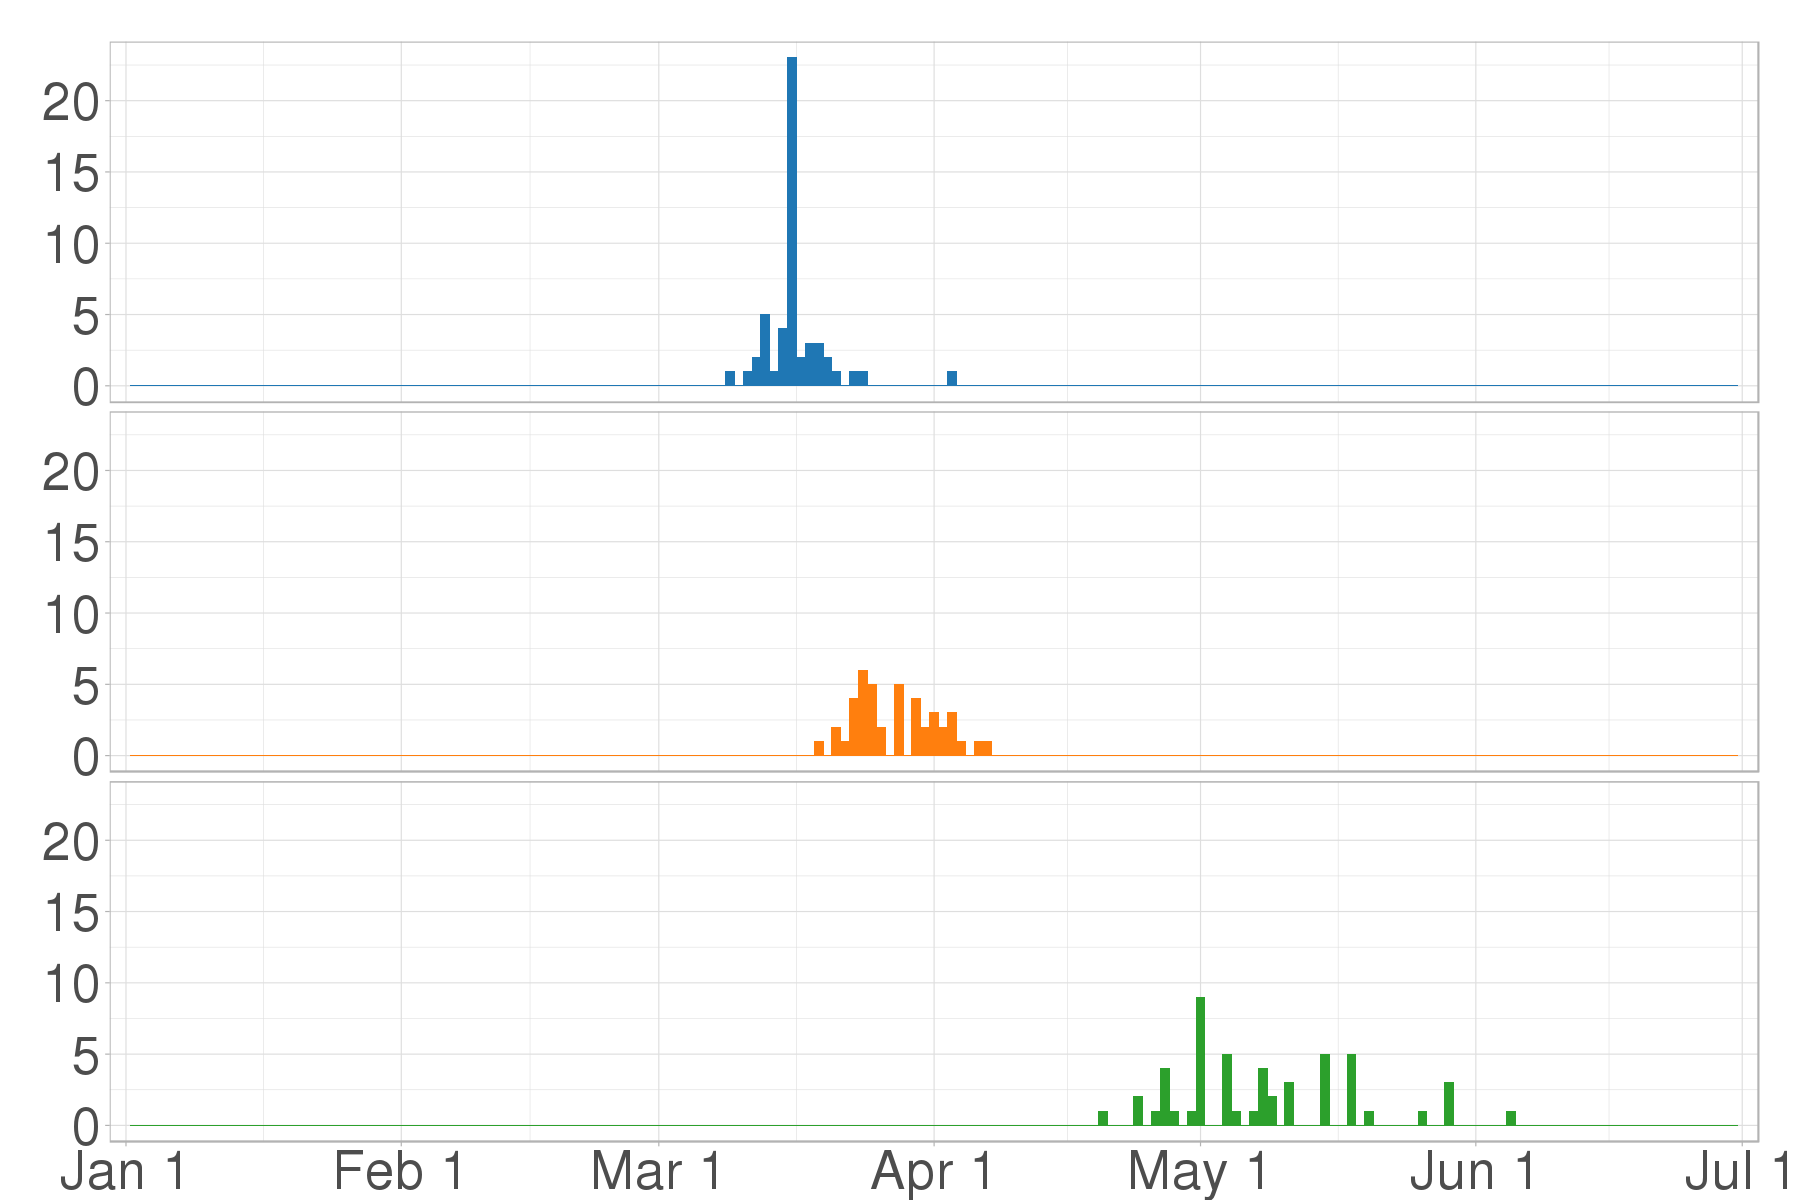

In [7]:
options(repr.plot.width=15, repr.plot.height=10)
pn <- c('p1sdp' = "Initial Policies",
        'p2shp' = "Shelter-in-place",
        'p3rop' = "Reopening")

policy %>%
    mutate(state = str_sub(key, 1, 2)) %>%
    select(state, p1sdp, p2shp, p3rop)  %>%
    distinct() %>%
    gather(key = 'policy', value = 'dateStart', -state) %>%
    ggplot(aes(x = dateStart, fill =  policy)) + 
    geom_histogram(binwidth = 1) +
    facet_grid(policy ~ ., labeller = as_labeller(pn)) +
    scale_fill_d3() +
    scale_x_date(date_breaks = '1 month', 
                 lim = c(as.Date('2020-01-01'), as.Date('2020-07-01')), 
                 labels = date_format("%b %-d"),
                 expand = c(0.01, 0.01)) +
    theme_light() + 
    xlab('') + 
    ylab('') +
    theme(text = element_text(size = 40),
          axis.title = element_blank(),
          strip.text.y = element_blank(),
          legend.position = 'None',
          plot.margin= margin(25, 25, 0, 25)) -> p1c

ggsave('/home/mfzhao/p1/p1c.svg', p1c, device = 'svg', width = 9, height = 4.5, scale = 2)
p1c

In [56]:
dyad %>%
    filter(destination_county == '06075') %>%
    mutate(dd = as.numeric(date - as.Date('2020-03-16'))) %>%
    filter(abs(dd) <= 21, dd != 21) %>%
    mutate(ro = ifelse(dd < 0, 'no', 'yes')) %>%
    group_by(ro, origin_county, destination_county) %>%
    summarize(n = sum(n)) %>%
    spread(key = ro, value = n) %>%
    replace_na(list(yes = 0, no = 0)) %>%
    mutate(diff = asinh(yes) - asinh(no)) %>%
    arrange(diff) -> sf

counties_sf %>%
    left_join(sf,
              by = c('county_fips' = 'origin_county')) %>%
    ggplot(aes(fill = diff)) +
    geom_sf(lwd = 0, color = NA) +
    scale_fill_viridis(option = 'D', lim = c(-5, 5), na.value = 'grey80') +
    xlab('') + 
    ylab('') +
    ggtitle('Lockdown: San Francisco County, CA') +
    labs(color = "Outcome") +
    theme_light() +
    theme(text = element_text(size=30),
          plot.title = element_text(vjust = -2, hjust = .75, size=20),
          legend.position = 'None',
          strip.text.y = element_blank(),
          panel.border = element_blank(),
          panel.grid.major=element_blank(), ## element_line(colour = "white")
          panel.grid.minor=element_blank(), ## element_line(colour = "white", size = 0.25)
          axis.ticks=element_blank(),       ## element_line(colour = "grey20")
          axis.text=element_blank(),        ## element_text(size = rel(0.8), colour = "grey30")
          axis.title=element_blank(),      ## axis.title.x = element_text(
          plot.margin=  margin(0, 0, 0, 0)) -> p1b1
#ggsave('/home/mfzhao/p1/p1b1.svg', p1b1, device = 'svg', width = 5, height = 3, scale = 2)

dyad %>%
    filter(destination_county == '06075') %>%
    mutate(dd = as.numeric(date - as.Date('2020-05-17'))) %>%
    filter(abs(dd) <= 21, dd != 21) %>%
    mutate(ro = ifelse(dd < 0, 'no', 'yes')) %>%
    group_by(ro, origin_county, destination_county) %>%
    summarize(n = sum(n)) %>%
    spread(key = ro, value = n) %>%
    replace_na(list(yes = 0, no = 0)) %>%
    mutate(diff = asinh(yes) - asinh(no)) %>%
    arrange(diff) -> sf

counties_sf %>%
    left_join(sf,
              by = c('county_fips' = 'origin_county')) %>%
    ggplot(aes(fill = diff)) +
    geom_sf(lwd = 0, color = NA) +
    scale_fill_viridis(option = 'D', lim = c(-5, 5), na.value = 'grey80') +
    xlab('') + 
    ylab('') +
    labs(color = "Outcome") +
    ggtitle('Reopening: San Francisco County, CA') +
    theme_light() +
    theme(text = element_text(size=30),
          plot.title = element_text(vjust = -2, hjust = .75, size=20),
          legend.position = 'None',
          strip.text.y = element_blank(),
          panel.border = element_blank(),
          panel.grid.major=element_blank(), ## element_line(colour = "white")
          panel.grid.minor=element_blank(), ## element_line(colour = "white", size = 0.25)
          axis.ticks=element_blank(),       ## element_line(colour = "grey20")
          axis.text=element_blank(),        ## element_text(size = rel(0.8), colour = "grey30")
          axis.title=element_blank(),      ## axis.title.x = element_text(
          plot.margin=  margin(0, 0, 0, 0)) -> p1b2
#ggsave('/home/mfzhao/p1/p1b2.svg', p1b2, device = 'svg', width = 5, height = 3, scale = 2)

dyad %>%
    filter(destination_county == '13051') %>%
    mutate(dd = as.numeric(date - as.Date('2020-04-03'))) %>%
    filter(abs(dd) <= 21, dd != 21) %>%
    mutate(ro = ifelse(dd < 0, 'no', 'yes')) %>%
    group_by(ro, origin_county, destination_county) %>%
    summarize(n = sum(n)) %>%
    spread(key = ro, value = n) %>%
    replace_na(list(yes = 0, no = 0)) %>%
    mutate(diff = asinh(yes) - asinh(no)) %>%
    arrange(diff) -> sf

counties_sf %>%
    left_join(sf,
              by = c('county_fips' = 'origin_county')) %>%
    ggplot(aes(fill = diff)) +
    geom_sf(lwd = 0, color = NA) +
    scale_fill_viridis(option = 'D', lim = c(-5, 5), na.value = 'grey80') +
    xlab('') + 
    ylab('') +
    labs(color = "Outcome") +
    theme_light() +
    theme(text = element_text(size=14),
          plot.title = element_text(vjust = -2, hjust = .75, size=20),
          legend.position = 'None',
          strip.text.y = element_blank(),
          panel.border = element_blank(),
          panel.grid.major=element_blank(), ## element_line(colour = "white")
          panel.grid.minor=element_blank(), ## element_line(colour = "white", size = 0.25)
          axis.ticks=element_blank(),       ## element_line(colour = "grey20")
          axis.text=element_blank(),        ## element_text(size = rel(0.8), colour = "grey30")
          axis.title=element_blank(),      ## axis.title.x = element_text(
           plot.margin=  margin(0, 0, 0, 0)) + 
    ggtitle('Lockdown: Chatham County, GA') -> p1b3
#ggsave('/home/mfzhao/p1/p1b3.svg', p1b3, device = 'svg', width = 5, height = 3, scale = 2)

dyad %>%
    filter(destination_county == '13051') %>%
    mutate(dd = as.numeric(date - as.Date('2020-04-25'))) %>%
    filter(abs(dd) <= 21, dd != 21) %>%
    mutate(ro = ifelse(dd < 0, 'no', 'yes')) %>%
    group_by(ro, origin_county, destination_county) %>%
    summarize(n = sum(n)) %>%
    spread(key = ro, value = n) %>%
    replace_na(list(yes = 0, no = 0)) %>%
    mutate(diff = asinh(yes) - asinh(no)) %>%
    arrange(diff) -> chatham

counties_sf %>%
    left_join(chatham,
              by = c('county_fips' = 'origin_county')) %>%
    ggplot(aes(fill = diff)) +
    geom_sf(lwd = 0, color = NA) +
    scale_fill_viridis(option = 'D', lim = c(-5, 5), na.value = 'grey80', breaks = c(-5, 0 , 5)) +
    guides(fill = guide_colorbar(direction = 'horizontal',
                                 barwidth  = 10,
                                 title.position = 'bottom',
                                 title='log(Post) - log(Pre)'),
                                 position=c(.69,.11)) + 
    xlab('') + 
    ylab('') +
    labs(fill = '') +
    theme_light() +
    theme(text = element_text(size=14),
          plot.title = element_text(vjust = -2, hjust = .75, size=20),
          legend.background = element_blank(),
          strip.text.y = element_blank(),
          panel.border = element_blank(),
          panel.grid.major=element_blank(), ## element_line(colour = "white")
          panel.grid.minor=element_blank(), ## element_line(colour = "white", size = 0.25)
          axis.ticks=element_blank(),       ## element_line(colour = "grey20")
          axis.text=element_blank(),        ## element_text(size = rel(0.8), colour = "grey30")
          axis.title=element_blank(),      ## axis.title.x = element_text(
           plot.margin=  margin(0, 0, 0, 0)) + 
    ggtitle('Reopening: Chatham County, GA') -> p1b4
#ggsave('/home/mfzhao/p1/p1b4.svg', p1b4, device = 'svg', width = 5, height = 3, scale = 2)

TableGrob (1 x 1) "arrange": 1 grobs
  z     cells    name            grob
1 1 (1-1,1-1) arrange gtable[arrange]

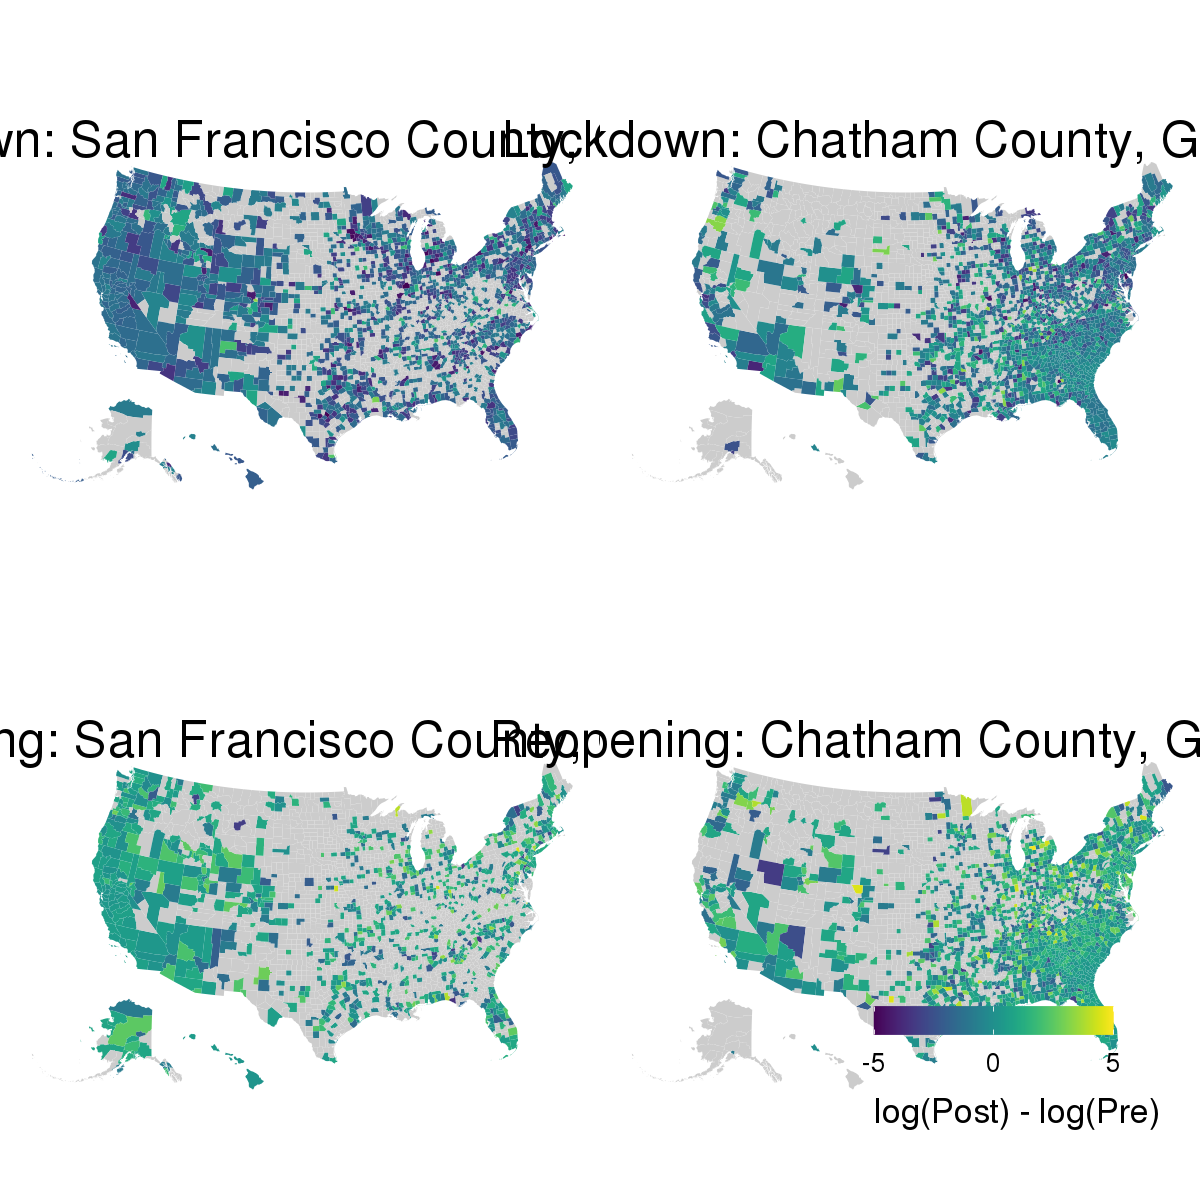

In [57]:
g2 <- arrangeGrob(grobs = list(p1b1, p1b2, p1b3, p1b4), layout_matrix = lay2)
p3_new <- grid.arrange(g2)
p3_new
ggsave('/home/dholtz/p3_new.pdf', p3_new, device = 'pdf', width = 9, height = 6, scale = 2)

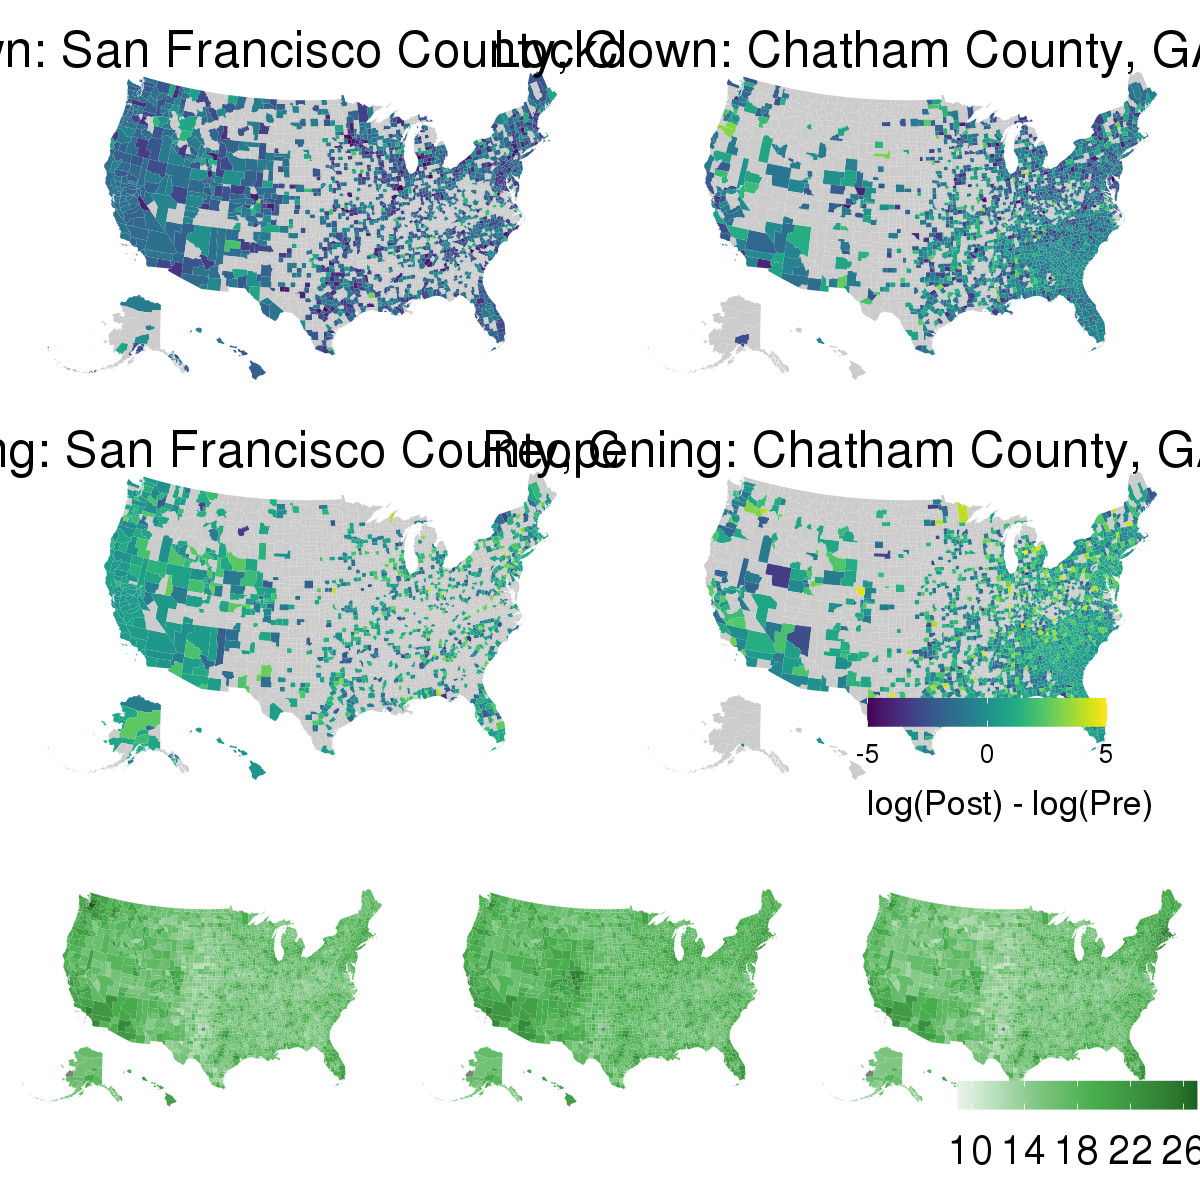

In [42]:
#lay2 <- cbind(rbind(1,2), rbind(3,4))
#lay4 <- cbind(1,2,3)

g2 <- arrangeGrob(grobs = list(p1b1, p1b2, p1b3, p1b4), layout_matrix = lay2)
g4 <- arrangeGrob(grobs = list(p1d1, p1d2, p1d3), layout_matrix = lay4)

#lay <- rbind(rep(1, 25),
#             rep(1, 25),
#             rep(1, 25),
#             rep(1, 25),
#             rep(1, 25),
#             rep(1, 25),
#             rep(1, 25),
#             rep(1, 25),
#             rep(1, 25),
#             rep(1, 25),
#             rep(2, 25),
#             rep(2, 25),
#             rep(2, 25),
#             rep(2, 25),
#             rep(2, 25))
#grid.arrange(grobs = list(g2, g4), layout_matrix = lay) -> p1

In [114]:
counties_sf %>%
    left_join(sci %>%
              filter(user_county == '53033') %>%
              rename(county_fips = fr_county)) %>%
    ggplot(aes(fill = log(w))) +
    geom_sf(lwd = 0, color = NA) +
    scale_fill_material('green') +  
    xlab('') + 
    ylab('') +
    guides(fill = guide_colorbar(direction = 'horizontal',
                                 barwidth  = 10,
                                 title.position = 'top')) + 
    labs(fill = '') +
    theme_light() +
    ggtitle('King County, WA') +
    theme(text = element_text(size=45),
          plot.title = element_text(vjust = -2, hjust = .6),
          legend.position = 'None',
          strip.text.y = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_blank(), ## element_line(colour = "white")
          panel.grid.minor = element_blank(), ## element_line(colour = "white", size = 0.25)
          axis.ticks = element_blank(),       ## element_line(colour = "grey20")
          axis.text = element_blank(),        ## element_text(size = rel(0.8), colour = "grey30")
          axis.title = element_blank(),      ## axis.title.x = element_text(
          plot.margin = unit(c(0, 0, 0, 0), "in")) -> p1d1

#ggsave('/home/mfzhao/p1/p1d1.svg', p1d1, device = 'svg', width = 5, height = 3, scale = 2)

counties_sf %>%
    left_join(sci %>%
              filter(user_county == '08013') %>%
              rename(county_fips = fr_county)) %>%
    ggplot(aes(fill = log(w))) +
    geom_sf(lwd = 0, color = NA) +
    scale_fill_material('green', lim = c(9, 27), breaks = c(10, 14, 18, 22, 26)) +  
    xlab('') + 
    ylab('') +
    guides(fill = guide_colorbar(direction = 'horizontal',
                                 barwidth  = 10,
                                 title.position = 'top')) + 
    labs(fill = '') +
    theme_light() +
    ggtitle('Boulder County, CO') + 
    theme(text = element_text(size=45),
          plot.title = element_text(vjust = -2, hjust = .6),
          legend.position = 'None',
          strip.text.y = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_blank(), ## element_line(colour = "white")
          panel.grid.minor = element_blank(), ## element_line(colour = "white", size = 0.25)
          axis.ticks = element_blank(),       ## element_line(colour = "grey20")
          axis.text = element_blank(),        ## element_text(size = rel(0.8), colour = "grey30")
          axis.title = element_blank(),      ## axis.title.x = element_text(
          plot.margin = unit(c(0, 0, 0, 0), "in")) -> p1d2

#ggsave('/home/mfzhao/p1/p1d2.svg', p1d2, device = 'svg', width = 5, height = 3, scale = 2)

counties_sf %>%
    left_join(sci %>%
              filter(user_county == '25025') %>%
              rename(county_fips = fr_county)) %>%
    ggplot(aes(fill = log(w))) +
    geom_sf(lwd = 0, color = NA) +
    scale_fill_material('green', lim = c(9, 27), breaks = c(10, 14, 18, 22, 26)) +  
    xlab('') + 
    ylab('') +
    guides(fill = guide_colorbar(direction = 'horizontal',
                                 barwidth  = 10,
                                 title.position = 'bottom',
                                 title='log(weighted SCI)'),
                                 position='right') + 
    labs(fill = '') +
    theme_light() +
    ggtitle('Suffolk County, MA') + 
    theme(text = element_text(size=45),
          plot.title = element_text(vjust = -2, hjust = .6),
          legend.title = element_text(size=30),
          legend.position = c(.78,.05),#'bottom',#c(.69, .11),
          legend.background = element_blank(),
          strip.text.y = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_blank(), ## element_line(colour = "white")
          panel.grid.minor = element_blank(), ## element_line(colour = "white", size = 0.25)
          axis.ticks = element_blank(),       ## element_line(colour = "grey20")
          axis.text = element_blank(),        ## element_text(size = rel(0.8), colour = "grey30")
          axis.title = element_blank(),      ## axis.title.x = element_text(
          plot.margin = unit(c(0, 0, 0, 0), "in"),
          legend.title.align=.5,
          legend.text = element_text(size=20)) -> p1d3

#ggsave('/home/mfzhao/p1/p1d3.svg', p1d3, device = 'svg', width = 5, height = 3, scale = 2)

Joining, by = "county_fips"

Joining, by = "county_fips"

Joining, by = "county_fips"



TableGrob (1 x 1) "arrange": 1 grobs
  z     cells    name            grob
1 1 (1-1,1-1) arrange gtable[arrange]

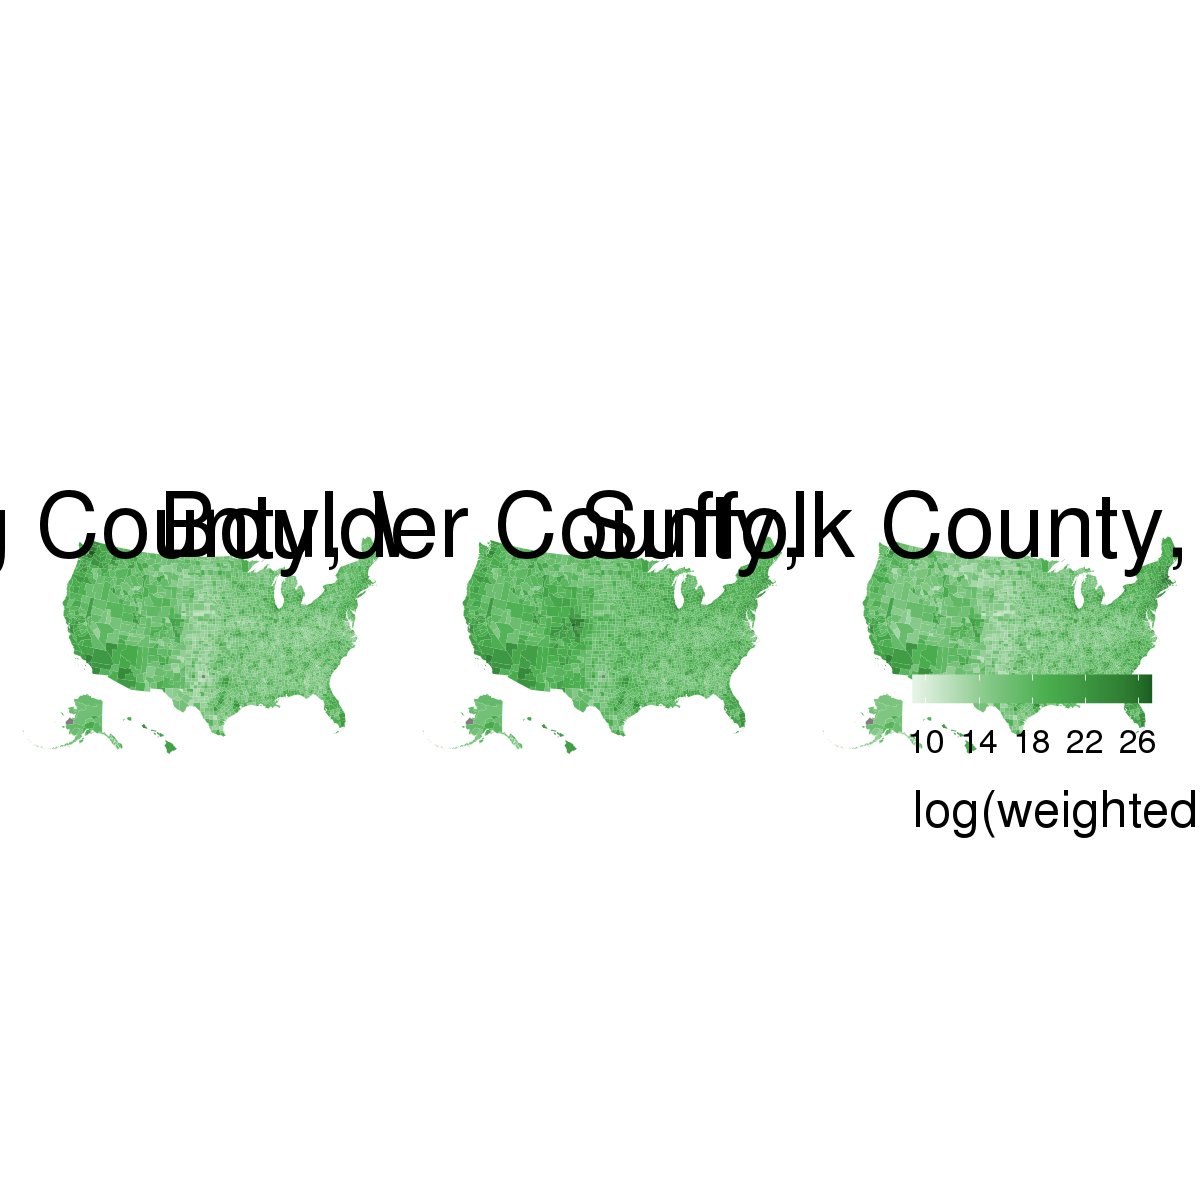

In [116]:
g4 <- arrangeGrob(grobs = list(p1d1, p1d2, p1d3), layout_matrix = lay4)
p2_new <- grid.arrange(g4)
p2_new
ggsave('/home/dholtz/p2_new.pdf', p2_new, device = 'pdf', width = 15, height = 5, scale = 2)

In [47]:
lay2 <- rbind(1,2,3,4)
lay4 <- cbind(1,2,3)

In [48]:
g2 <- arrangeGrob(grobs = list(p1b1, p1b2, p1b3, p1b4), layout_matrix = lay2)
g4 <- arrangeGrob(grobs = list(p1d1, p1d2, p1d3), layout_matrix = lay4)

Warning message:
“Removed 90 row(s) containing missing values (geom_path).”
Warning message:
“Removed 8 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 6 rows containing missing values (geom_bar).”


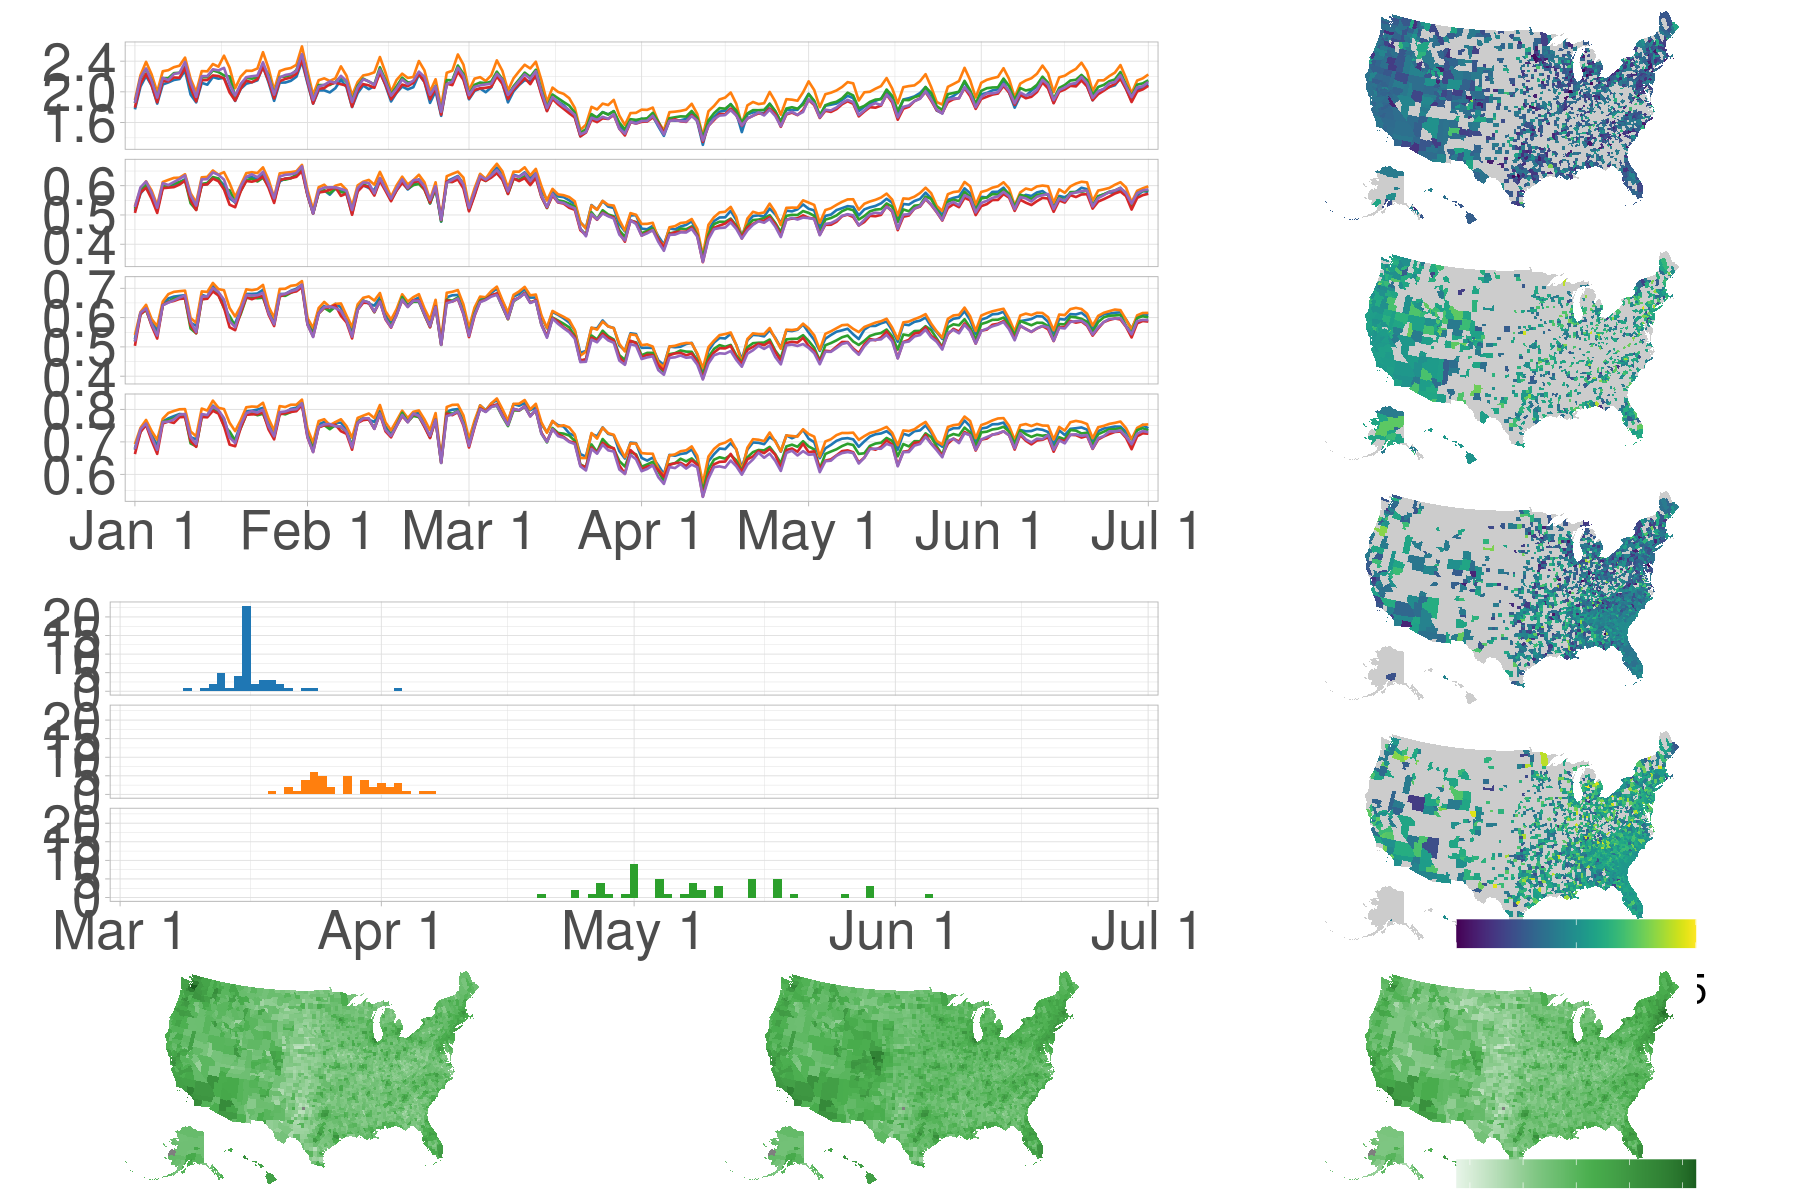

In [49]:
lay <- rbind(c(rep(1, 10), rep(2, 5)),
             c(rep(1, 10), rep(2, 5)),
             c(rep(1, 10), rep(2, 5)),
             c(rep(1, 10), rep(2, 5)),
             c(rep(1, 10), rep(2, 5)),
             c(rep(1, 10), rep(2, 5)),
             c(rep(1, 10), rep(2, 5)),
             c(rep(3, 10), rep(2, 5)),
             c(rep(3, 10), rep(2, 5)),
             c(rep(3, 10), rep(2, 5)),
             c(rep(3, 10), rep(2, 5)),
             c(rep(3, 10), rep(2, 5)),
             rep(4, 15),
             rep(4, 15),
             rep(4, 15))
grid.arrange(grobs = list(p1a, g2, p1c, g4), layout_matrix = lay) -> p1

In [50]:
ggsave('/home/mfzhao/p1.pdf', p1, device = 'pdf', width = 15, height = 15, scale = 2)

Joining, by = "county_fips"



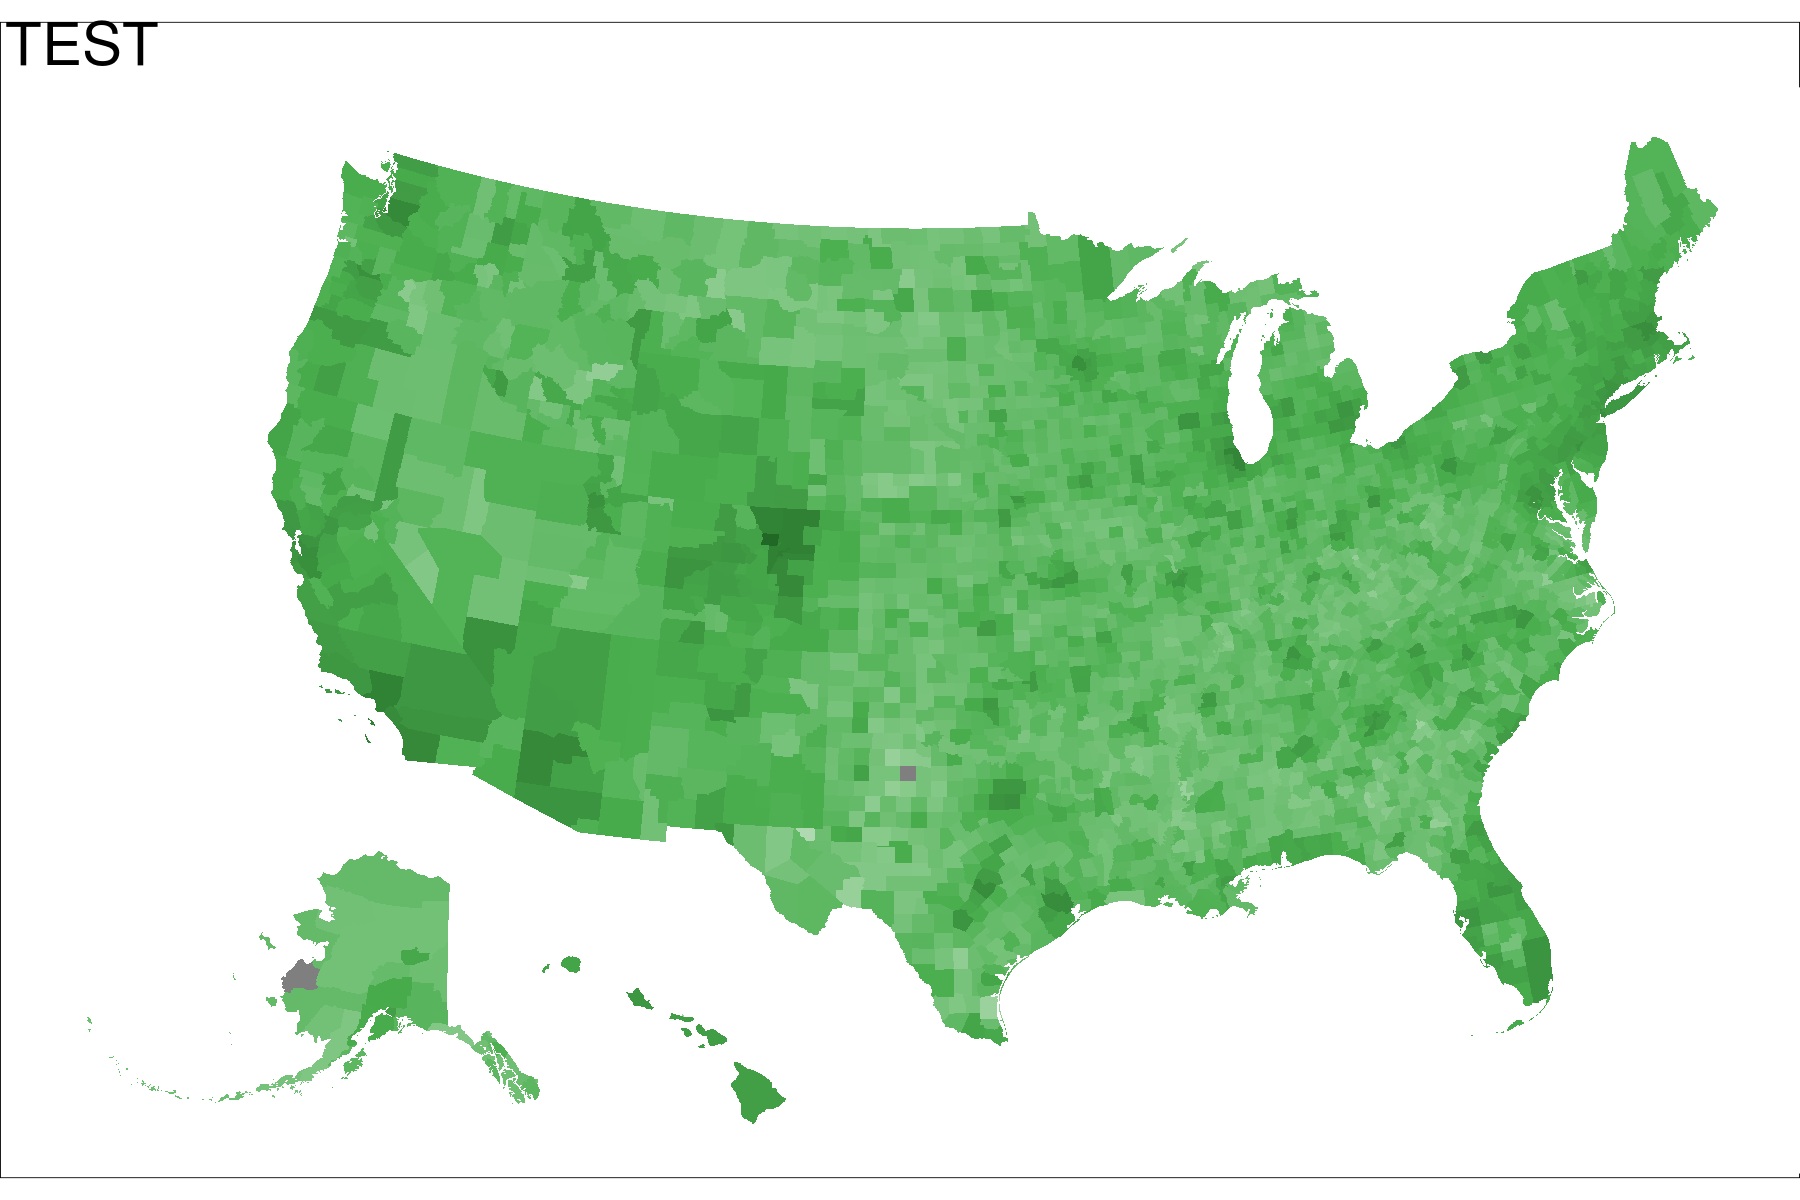

In [54]:
counties_sf %>%
    left_join(sci %>%
              filter(user_county == '08013') %>%
              rename(county_fips = fr_county)) %>%
    ggplot(aes(fill = log(w))) +
    geom_sf(lwd = 0, color = NA) +
    scale_fill_material('green', lim = c(9, 27), breaks = c(10, 14, 18, 22, 26)) +  
    xlab('') + 
    ylab('') +
    guides(fill = guide_colorbar(direction = 'horizontal',
                                 barwidth  = 10,
                                 title.position = 'top')) + 
    labs(fill = '') +
    theme_light() +
    ggtitle('TEST') + 
    theme(text = element_text(size=30),
          legend.position = 'None',
          strip.text.y = element_blank(),
          plot.background = element_rect(color = 'black'),
          panel.border = element_blank(),
          panel.grid.major = element_blank(), ## element_line(colour = "white")
          panel.grid.minor = element_blank(), ## element_line(colour = "white", size = 0.25)
          axis.ticks = element_blank(),       ## element_line(colour = "grey20")
          axis.text = element_blank(),        ## element_text(size = rel(0.8), colour = "grey30")
          axis.title = element_blank(),      ## axis.title.x = element_text(
          plot.margin = unit(c(0, 0, 0, 0), "in"))